# VGG implementation in TensorFlow Slim

[VGGNet](https://arxiv.org/pdf/1409.1556.pdf) to classify flowers into the 17 categories of the Oxford Flowers data set.

## Preliminary steps

### Global params

In [1]:
epochs = 1
batch_size = 32
test_size = 0.1
pool_size = 2
n_maxpool_layers = 5
padding = 'VALID'
dropout = 0.5
display_steps = 2
learning_rate = 1e-4

### Set seed

In [2]:
import numpy as np
np.random.seed(42)

### Load dependencies

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math

### Load the data

In [4]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(one_hot=True)

In [5]:
num_examples, img_height, img_width, img_channels = X.shape

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=test_size, random_state=42)

In [6]:
print("Shape of training set {}".format(X_train.shape))

Shape of training set (1224, 224, 224, 3)


In [7]:
print("Shape of labels {}".format(Y_train.shape))

Shape of labels (1224, 17)


In [8]:
n_classes = Y.shape[1]
print(n_classes)

17


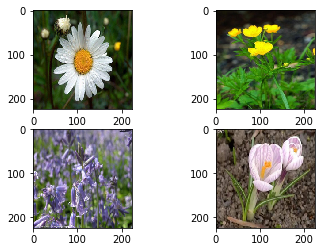

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(2,2)
axes[0,0].imshow(X_train[0])
axes[0,1].imshow(X_train[1])
axes[1,0].imshow(X_train[2])
axes[1,1].imshow(X_train[3])

In [10]:
print(Y_train[0:4])

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


## Define the network architecture

In [11]:
#x = tf.placeholder(tf.float32, shape=[None, img_height, img_width, img_channels])
#y_ = tf.placeholder(tf.float32, shape=[None, n_classes])
#keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

### Network

In [12]:
# Parameters

# Conv 1
k_conv1 = 3
n_conv1 = 64

# Conv 2
k_conv2 = 3
n_conv2 = 128

# Conv 3
k_conv3 = 3
n_conv3 = 256

# Conv 4
k_conv4 = 3
n_conv4 = 512

# Conv 5
k_conv5 = 3
n_conv5 = 512

# FC 6
n_fc6 = 4096

# FC 7
n_fc7 = 4096

In [13]:
def vgg16(x, debug, batch_norm=True):
    max_pool_stride=2
    wt_init=tf.contrib.layers.xavier_initializer()
    net = x
    # convolution 1
    with tf.name_scope('conv1'):
        for _ in range(2):
            net = tf.layers.conv2d(net, n_conv1, [k_conv1, k_conv1], padding=padding,
                                   activation=tf.nn.relu, kernel_initializer=wt_init)
    net = tf.layers.max_pooling2d(net, pool_size, max_pool_stride, padding=padding, name='pool1')
    if batch_norm:
        net = tf.layers.batch_normalization(net)
    if debug:
        print('Conv1 shape {}'.format(net.shape))
            
    # convolution 2
    with tf.name_scope('conv2'):
        for _ in range(2):
            net = tf.layers.conv2d(net, n_conv2, [k_conv2, k_conv2], padding=padding,
                                   activation=tf.nn.relu, kernel_initializer=wt_init)
    net = tf.layers.max_pooling2d(net, pool_size, max_pool_stride, padding=padding, name='pool2')
    if batch_norm:
        net = tf.layers.batch_normalization(net)
    if debug:
        print('Conv2 shape {}'.format(net.shape))

    # convolution 3
    with tf.name_scope('conv3'):
        for _ in range(3):
            net = tf.layers.conv2d(net, n_conv3, [k_conv3, k_conv3], padding=padding,
                                   activation=tf.nn.relu, kernel_initializer=wt_init)
    net = tf.layers.max_pooling2d(net, pool_size, max_pool_stride, padding=padding, name='pool3')
    if batch_norm:
        net = tf.layers.batch_normalization(net)
    if debug:
        print('Conv3 shape {}'.format(net.shape))

    # convolution 4
    with tf.name_scope('conv4'):
        for _ in range(3):
            net = tf.layers.conv2d(net, n_conv4, [k_conv4, k_conv4], padding=padding,
                                   activation=tf.nn.relu, kernel_initializer=wt_init)
    net = tf.layers.max_pooling2d(net, pool_size, max_pool_stride, padding=padding, name='pool4')
    if batch_norm:
        net = tf.layers.batch_normalization(net)
    if debug:
        print('Conv4 shape {}'.format(net.shape))
            
    # convolution 5
    with tf.name_scope('conv5'):
        for _ in range(3):
            net = tf.layers.conv2d(net, n_conv5, [k_conv5, k_conv5], padding=padding,
                                   activation=tf.nn.relu, kernel_initializer=wt_init)
    net = tf.layers.max_pooling2d(net, pool_size, max_pool_stride, padding=padding, name='pool5')
    if batch_norm:
        net = tf.layers.batch_normalization(net)
    if debug:
        print('Conv5 shape {}'.format(net.shape))
            
    # tf.summary.histogram('pool_5', net)
        
    # fully connected layers
    
    # Compute dense layer size
    if padding == 'SAME':
        downsampling_factor = math.pow(pool_size, n_maxpool_layers)
        dense_layer_size = int(img_height / downsampling_factor) * int(img_width / downsampling_factor) * n_conv5
    else:
        dense_layer_size = n_conv5
        
    net = tf.reshape(net,[-1, dense_layer_size]) # flatten
    net = tf.layers.dense(net, n_fc6, name='fc6',
                          activation=tf.nn.relu, kernel_initializer=wt_init)
    net = tf.nn.dropout(net, 1.0 - dropout, name='dropout6')
    net = tf.layers.dense(net, n_fc7, name='fc7',
                          activation=tf.nn.relu, kernel_initializer=wt_init)
    net = tf.nn.dropout(net, 1.0 - dropout, name='dropout7')
    net = tf.layers.dense(net, n_classes, kernel_initializer=wt_init, name='fc8')
        
    # tf.summary.histogram('scores', net)

    return net

## Run the architecture

### Build the model

In [14]:
def model_fn(features, labels, mode, params):
    """Model function for Estimator."""

    # TODO: add tensorboard
    
    output = vgg16(features["x"], False)

    predictions = tf.argmax(output, 1)

    # Provide an estimator spec for `ModeKeys.PREDICT`.
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={"classes": predictions})

    # Calculate loss using cross entropy
    loss = tf.losses.softmax_cross_entropy(labels, output)
    tf.summary.scalar('loss', loss)

    # Calculate accuracy as additional eval metric
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(tf.argmax(labels, 1), predictions)
    }

    # TODO: add accuracy to tensorboard summary
    
    optimizer = tf.train.AdamOptimizer(
        learning_rate=params["learning_rate"])
    train_op = optimizer.minimize(
      loss=loss, global_step=tf.train.get_global_step())

    # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops)

### Trainining

In [ ]:
# Set model params
model_params = {
    "learning_rate": learning_rate,
}

# Instantiate Estimator
nn = tf.estimator.Estimator(model_fn=model_fn, params=model_params)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=Y_train,
    batch_size=batch_size,
    num_epochs=None, # the model will train until the specified number of steps is reached.
    shuffle=True)

# Train
nn.train(input_fn=train_input_fn, steps=5000)

# Score accuracy
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test},
    y=Y_test,
    batch_size=batch_size,
    num_epochs=1, # the model evaluates the metrics over one epoch of data and returns the result
    shuffle=False)

ev = nn.evaluate(input_fn=test_input_fn)
print("Loss: %s" % ev["loss"])
print("Accuracy: %s" % ev["accuracy"])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfpp99e3l', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpfpp99e3l/model.ckpt.
INFO:tensorflow:loss = 2.83302, step = 1
INFO:tensorflow:global_step/sec: 1.98553
INFO:tensorflow:loss = 2.46058, step = 101 (50.365 sec)
INFO:tensorflow:global_step/sec: 1.97962
INFO:tensorflow:loss = 2.19421, step = 201 (50.515 sec)
INFO:tensorflow:global_step/sec: 1.97746
INFO:tensorflow:loss = 1.88038, step = 301 (50.570 sec)
INFO:tensorflow:global_step/sec: 1.97321
INFO:tensorflow:loss = 1.80839, step = 401 (50.679 sec)
INFO:tensorflow:global_step/sec: 1.97411
INFO:tensorflow:loss = 1.34286, step = 501 (50.656 sec)
INFO:tensorflow